In [2]:
import pandas as pd
import xgboost
import numpy as np
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [3]:
df = pd.read_csv("Boruta_Clono_14_No_LPS.csv")

In [4]:
#Using the 'plate' column as our label, dropping 'sampleid' column.
X = df.drop(columns=["sampleid", "plate"])
y = df['plate']

In [5]:
#This is vestigual and is optional in our specific case. Initially we labeled plates to include letters,
#this portion just ignores those letters.

y_encoded = pd.factorize(y)[0]

In [6]:
#Train-test split, the test_size is a percentage, I currently have it set to test 30% of the features randomly.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=123, stratify=y_encoded)

In [7]:
#Fit XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17


Confusion Matrix:
 [[9 0]
 [0 8]]


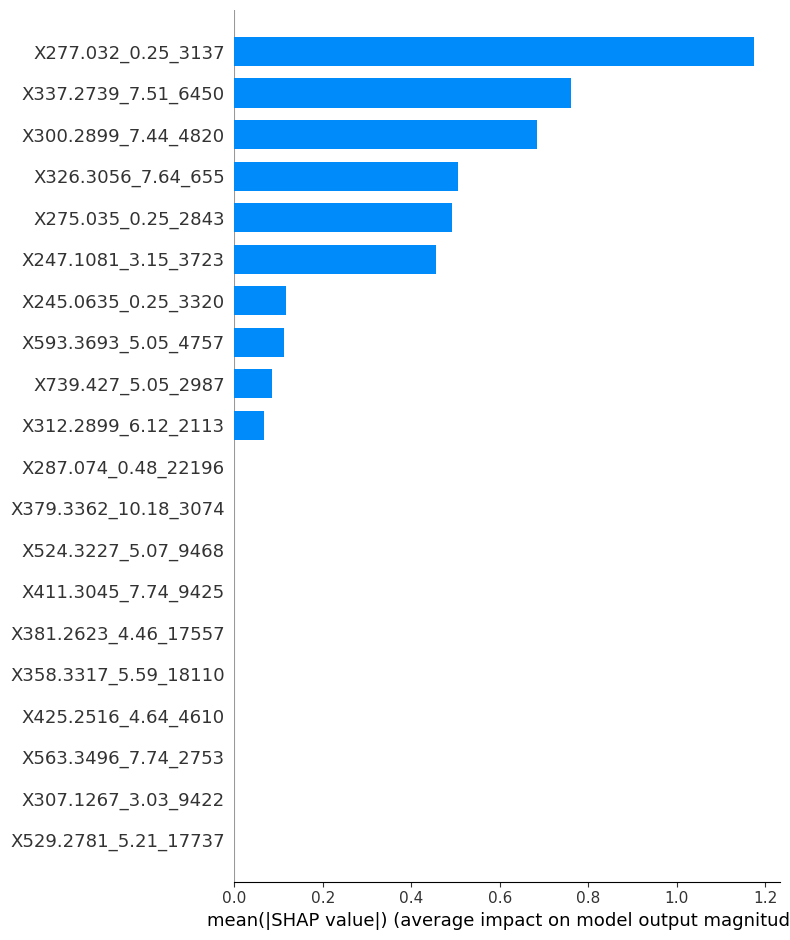

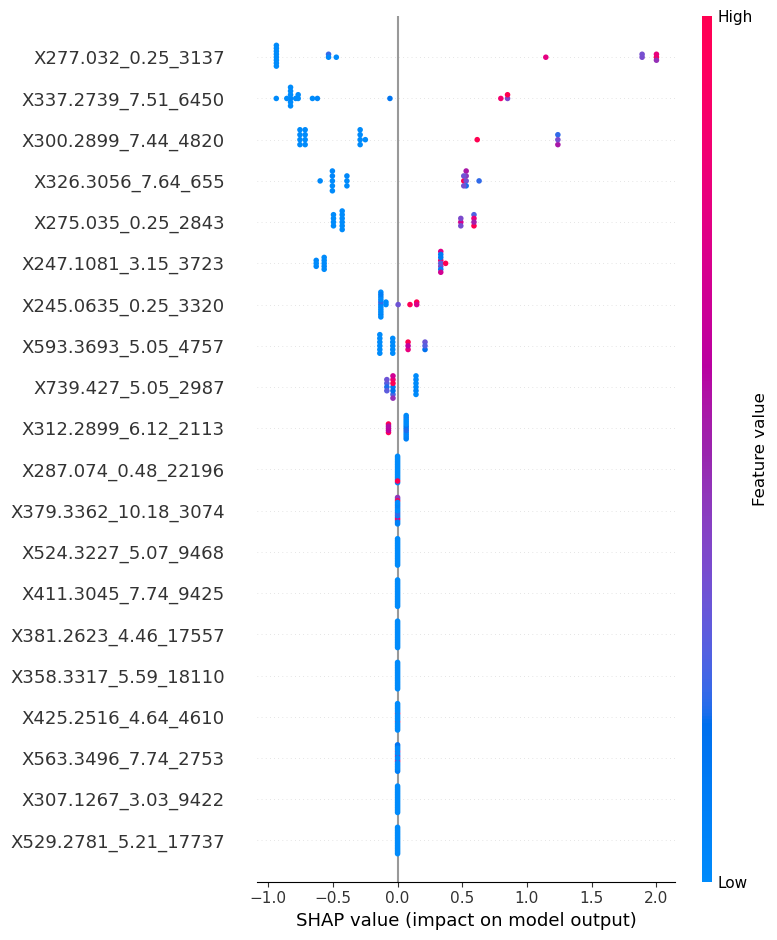

In [8]:
#Evaluate Model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

#Plots the top 20 most important features
xgboost.plot_importance(model, max_num_features=20)
plt.tight_layout()
plt.show()

#SHAP Explanation
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

#SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)  #full beeswarm plot

In [9]:
# === Stratified K-Fold CV ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(model, X, y_encoded, cv=skf)
print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Cross-validation scores: [0.90909091 0.90909091 0.81818182 0.90909091 0.8       ]
Mean accuracy: 0.8690909090909091


C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:
# === Plot CV scores ===
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='blue')
plt.title("Cross-Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
#Repeated Stratified K-Fold
#I prefer this over just the one and done measurement, this allows us to see how the model does after 50 iterations.
#The closer the mean is to 1 the more the model validates our Boruta run if the Boruta-created features.
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=123)
rep_scores = cross_val_score(model, X, y_encoded, cv=rskf)
print("All scores:", rep_scores)
print("Mean accuracy:", np.mean(rep_scores))
print("Standard deviation:", np.std(rep_scores))

plt.figure(figsize=(8, 4))
plt.plot(rep_scores, marker='o')
plt.axhline(np.mean(rep_scores), color='red', linestyle='--', label=f"Mean = {np.mean(rep_scores):.2f}")
plt.title("Repeated Stratified K-Fold Accuracy Scores")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    "kfold_accuracy_14days_Clono_No_LPS.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

All scores: [0.90909091 0.90909091 0.81818182 0.90909091 0.8        0.90909091
 0.72727273 0.90909091 0.90909091 1.         1.         0.81818182
 1.         0.90909091 0.8        0.81818182 1.         1.
 0.90909091 0.8        0.90909091 0.90909091 0.90909091 0.81818182
 0.8        1.         1.         0.72727273 0.90909091 0.7
 0.81818182 1.         1.         0.72727273 1.         0.90909091
 0.81818182 0.81818182 0.81818182 0.9        1.         0.90909091
 0.90909091 0.81818182 0.9        1.         1.         0.90909091
 0.72727273 0.9       ]
Mean accuracy: 0.8883636363636362
Standard deviation: 0.08765145098344995


In [12]:
#consider looking at LPS comparison to existing metabolite venn diagrams.